# Measuring surprise in LLM text generation

The objective of this notebook is to measure the _degrees of freedom_ LLMs experience while generating text token by token.

First, the required packages ---the most relevant ones being Huggingface's--- are loaded:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM

/home/carlos/.local/share/virtualenvs/huggingface-p54w0Sqk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will use the 7B Falcon model for text generation. Any other similar model from Huggingface should work similarly.

In [2]:
tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b")
model = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-7b")

The Falcon model was initialized without `trust_remote_code=True`, and will therefore leverage the transformers library implementation. tiiuae/falcon-7b's revision is set to a version that doesn't leverage remote code (4e2d06f0a7c6370ebabbc30c6f59377ae8f73d76).

In order to override this, please set a revision manually or set `trust_remote_code=True`.
2023-10-10 01:16:37.055957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 01:16:45.637958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading checkpoint shards: 100%|██████████| 2/2 [01:15<00:00, 37.50s/it]


Sorry, I was not particularly inspired here:

In [3]:
inputs = tokenizer("Never in the history of ", return_tensors="pt")

Now, we let the model suggest a continuation:

In [4]:
out = model.generate(
    **inputs,
    return_dict_in_generate=True,
    max_length= 40,
    output_scores=True)

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The current implementation of Falcon calls `torch.scaled_dot_product_attention` directly, this will be deprecated in the future in favor of the `BetterTransformer` API. Please install the latest optimum library with `pip install -U optimum` and call `model.to_bettertransformer()` to benefit from `torch.scaled_dot_product_attention` and future performance optimizations.


Which happens to be:

In [5]:
predicted_text = tokenizer.batch_decode(out['sequences'])
predicted_text

['Never in the history of “The Bachelor” has a contestant been so hated by the viewing public.\nThe “Bachelor” franchise has had its share of villains, but the one who has']

Which is composed of the following tokens:

In [6]:
tokens = [tokenizer.decode(x) for x in out['sequences'].numpy().reshape(-1).tolist()]
tokens

['Never',
 ' in',
 ' the',
 ' history',
 ' of',
 ' ',
 '“',
 'The',
 ' Bachelor',
 '”',
 ' has',
 ' a',
 ' contestant',
 ' been',
 ' so',
 ' hated',
 ' by',
 ' the',
 ' viewing',
 ' public',
 '.',
 '\n',
 'The',
 ' ',
 '“',
 'Bachelor',
 '”',
 ' franchise',
 ' has',
 ' had',
 ' its',
 ' share',
 ' of',
 ' villains',
 ',',
 ' but',
 ' the',
 ' one',
 ' who',
 ' has']

These are the _logits_ of the different tokens, large vectors (dimension +50k) of numbers _related to_ probabilities.

In [7]:
logits = out['scores']

These are the predicted tokens (net of the _prompt_):

In [8]:
predicted_tokens = tokens[-len(logits):]

Now, to measure the _degrees of freedom_, we are going to count smallest the number of tokens whose aggregated probability exceeds 10%. In reality, we are _miscalculating_ the probability in the formulas below: we should have used

$$p = \frac{\exp(l)}{1 + \exp(l)}$$

but these would not sum to 1. So we use an approximation, 

$$\hat{p} = \frac{exp(l)}{\sum_l \exp(l)},$$

which does.

In [47]:

def get_largest_probs(x):
    tmp = x.reshape(-1).numpy()
    probs = np.exp(tmp) / np.exp(tmp).sum()
    probs = np.cumsum(np.sort(probs))
    return (probs > .1).sum()

out_probs = pd.DataFrame.from_dict({
    'tokens' : predicted_tokens,
    'probs' : [get_largest_probs(x) for x in logits]
})


So, here are the _degrees of freedom_ for each token:

In [43]:
out_probs

,tokens,probs
0,“,42
1,The,1110
2,Bachelor,432
3,”,1
4,has,6
5,a,8
6,contestant,171
7,been,239
8,so,151
9,hated,917


And also nicely plotted:

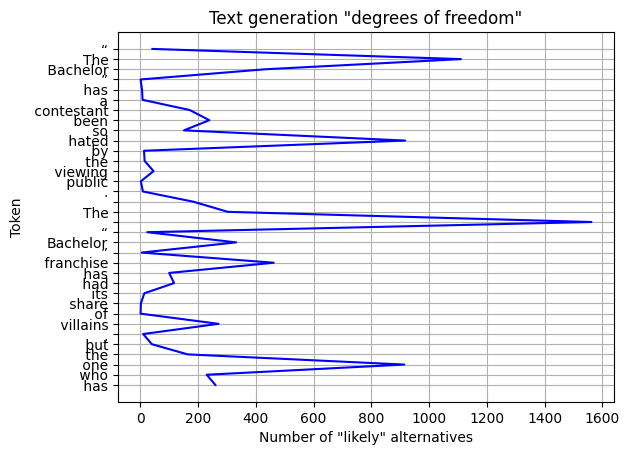

In [81]:
df = out_probs.copy()

df['order'] = df.index[::-1]


plt.plot(df.probs, df['order'], color='b')

plt.yticks(range(df.shape[0]), df.tokens.iloc[::-1])
plt.xlabel('Number of "likely" alternatives')
plt.ylabel('Token')
plt.title('Text generation "degrees of freedom"')
plt.grid(True)
plt.show();

You can see how after the quotes or after the _The_ following the full stop, the possibilities open for the LLM, whereas in other cases it is mostly forced to choose the token that was finally utilized. Etc.